In [1]:
´%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings

warnings.filterwarnings('ignore')

In [2]:
# Import the data
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from utils.dataset import get_train_test_data

# get the train and test data in rgb format
(train_data, train_labels), (test_data, test_labels) = get_train_test_data(rgb=True, verbose=True)
# Turn the labels into one-bit-hot-encoding
train_labels_cat, test_labels_cat = to_categorical(train_labels), to_categorical(test_labels)
# convert the data to grayscale
train_data_gs, test_data_gs = (
    tf.image.rgb_to_grayscale(train_data).numpy(),
    tf.image.rgb_to_grayscale(test_data).numpy()
)

2022-04-20 09:25:19.791902: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train samples: 60000
Test samples: 10000
Data shape: (28, 28, 3)


In [3]:
from utils.dataset import get_data_masks
from config_dirs import CLASSIFIER_PATH
import numpy as np

# load the model
classifier = tf.keras.models.load_model(f'../{CLASSIFIER_PATH}')

# load the predictions
predictions = np.loadtxt('../in/predictions.csv')
predictions_cat = to_categorical(predictions, num_classes=len(set(train_labels)))

# get the masks for the data
mask_miss, mask_label = get_data_masks(test_labels, predictions, label=5, verbose=True)


Found 892/10000 instances for the label 5
Found 167/892 instances for misclassified 5
        


In [4]:
base_dir = '../out/approaches/local_latent'

# Experiment with different configurations
Try different approaches for clustering the explanations.

In [9]:
from utils.cluster.compare import compare_approaches
from utils.general import beep
from xplique.attributions import GradCAMPP
from sklearn.manifold import TSNE
from sklearn.cluster import AffinityPropagation
from utils.cluster.ClusteringMode import LocalLatentMode

# create the explainer
explainer = GradCAMPP(classifier)
# generate the explanations
approaches = [
    LocalLatentMode(
        mask=mask_label,
        explainer = GradCAMPP(classifier),
        dim_red_techs=[TSNE(perplexity=perplexity)],
        clus_tech=AffinityPropagation()
    )
    for perplexity in [.5, 1, 3, 5, 7, 10]
]
df = compare_approaches(
    approaches=approaches,
    data=test_data,
    predictions=predictions_cat,
    iterations=5,
    verbose=True
)

beep()


approach: LocalLatentMode
explainer: GradCAMPP
clus_tech: AffinityPropagation
dim_red_techs: ['TSNE']
dim_red_techs_params: [{'angle': 0.5, 'early_exaggeration': 12.0, 'init': 'warn', 'learning_rate': 'warn', 'method': 'barnes_hut', 'metric': 'euclidean', 'min_grad_norm': 1e-07, 'n_components': 2, 'n_iter': 1000, 'n_iter_without_progress': 300, 'n_jobs': None, 'perplexity': 0.5, 'random_state': None, 'square_distances': 'legacy', 'verbose': 0}]
            
1/5 -> NO CLUSTERS
2/5 -> NO CLUSTERS
3/5 -> NO CLUSTERS
4/5 -> NO CLUSTERS
5/5 -> NO CLUSTERS

approach: LocalLatentMode
explainer: GradCAMPP
clus_tech: AffinityPropagation
dim_red_techs: ['TSNE']
dim_red_techs_params: [{'angle': 0.5, 'early_exaggeration': 12.0, 'init': 'warn', 'learning_rate': 'warn', 'method': 'barnes_hut', 'metric': 'euclidean', 'min_grad_norm': 1e-07, 'n_components': 2, 'n_iter': 1000, 'n_iter_without_progress': 300, 'n_jobs': None, 'perplexity': 1, 'random_state': None, 'square_distances': 'legacy', 'verbose'

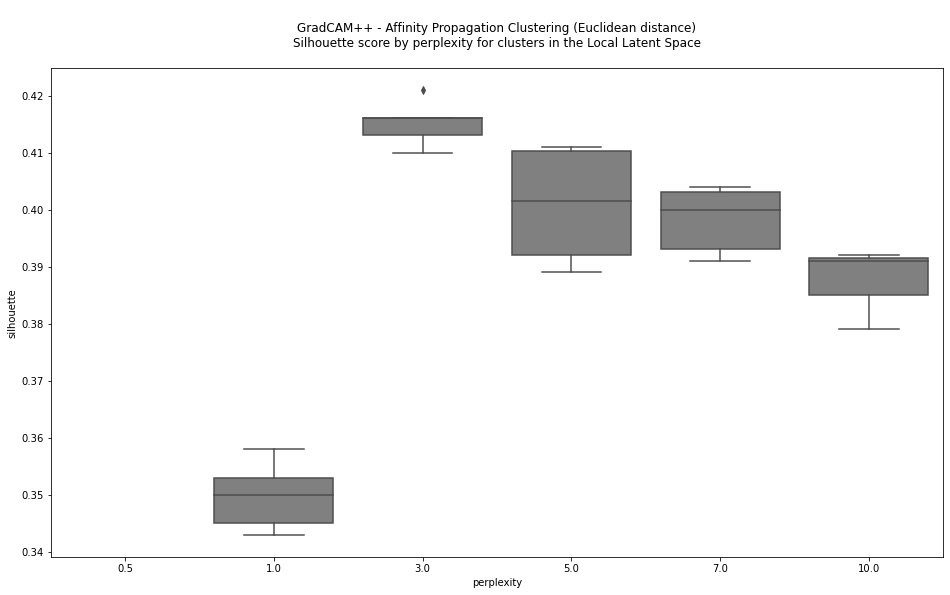

In [10]:
from utils.general import save_figure
import seaborn as sns
import matplotlib.pyplot as plt

# add a column with the perplexity value
df['perplexity'] = df['dim_red_techs_params'].apply(lambda params: float(params[0]['perplexity']))
# generate the boxplot for the different perplexity values
fig = plt.figure(figsize=(16, 9))
sns.boxplot(x='perplexity', y='silhouette', data=df, color='gray').set_title(
    """
GradCAM++ - Affinity Propagation Clustering (Euclidean distance)
Silhouette score by perplexity for clusters in the Local Latent Space
    """
)
save_figure(fig, f'{base_dir}/silhouette_by_perplexity')

# Plot the cluster in the lower dimensional space

In [42]:
from sklearn.cluster import AffinityPropagation
from utils.cluster.ClusteringMode import LocalLatentMode
from sklearn.manifold import TSNE

# create the approach corresponding to the best configuration
approach = LocalLatentMode(
    mask=mask_label,
    explainer=GradCAMPP(classifier),
    clus_tech=AffinityPropagation(),
    dim_red_techs=[TSNE(perplexity=3)]
)
# generate the contributions
contributions = approach.generate_contributions(test_data, predictions_cat)
# cluster the contributions
clusters, score, projections = approach.cluster_contributions(contributions)
print('Silhouette score: ', round(score, 3))

Silhouette score:  0.425


In [43]:
import numpy as np

# create the mask for the misclassified items of the selected label
mask_miss_label = mask_miss[mask_label]
# create the mask for the clusters containing misclassified elements of the selected label
mask_contains_miss_label = np.isin(clusters, np.unique(clusters[mask_miss_label]))

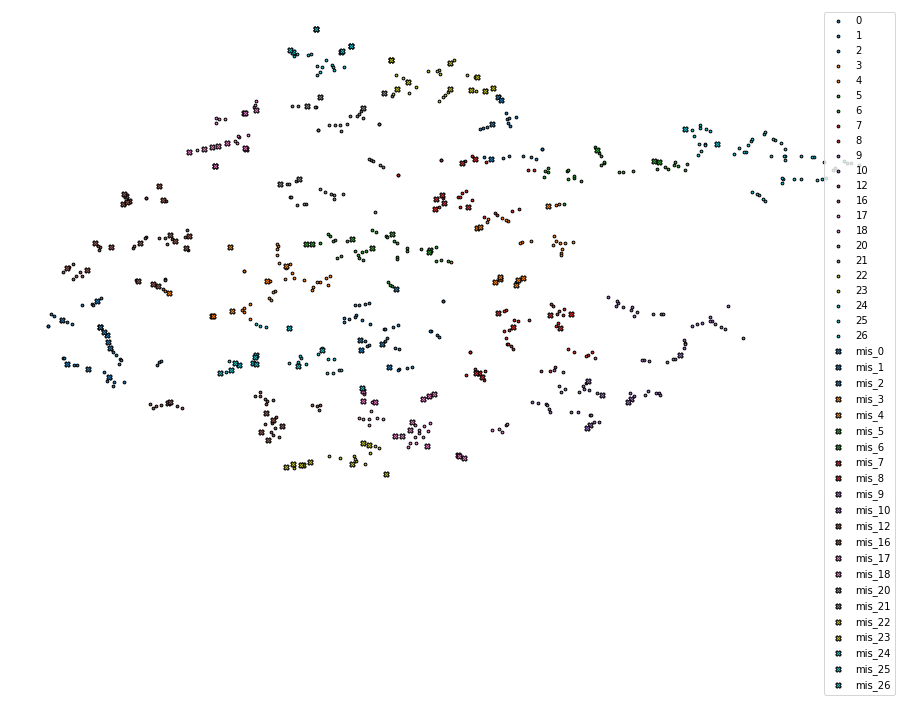

In [44]:
from utils.cluster.visualize import visualize_clusters_projections

# visualize the projections of the contributions for the correct predictions
fig, ax = visualize_clusters_projections(
    projections=projections[~mask_miss_label & mask_contains_miss_label],
    clusters=clusters[~mask_miss_label & mask_contains_miss_label],
    cmap='tab10', marker='.'
)
# visualize the projections of the contributions for the wrong predictions
visualize_clusters_projections(
    projections=projections[mask_miss_label],
    clusters=clusters[mask_miss_label],
    fig=fig, ax=ax, cmap='tab10', marker='X', label_prefix='mis'
)

# ax.set_title('Projections for the clusters containing both correct and incorrect classifications')
save_figure(fig, f'{base_dir}/clusters_projections')

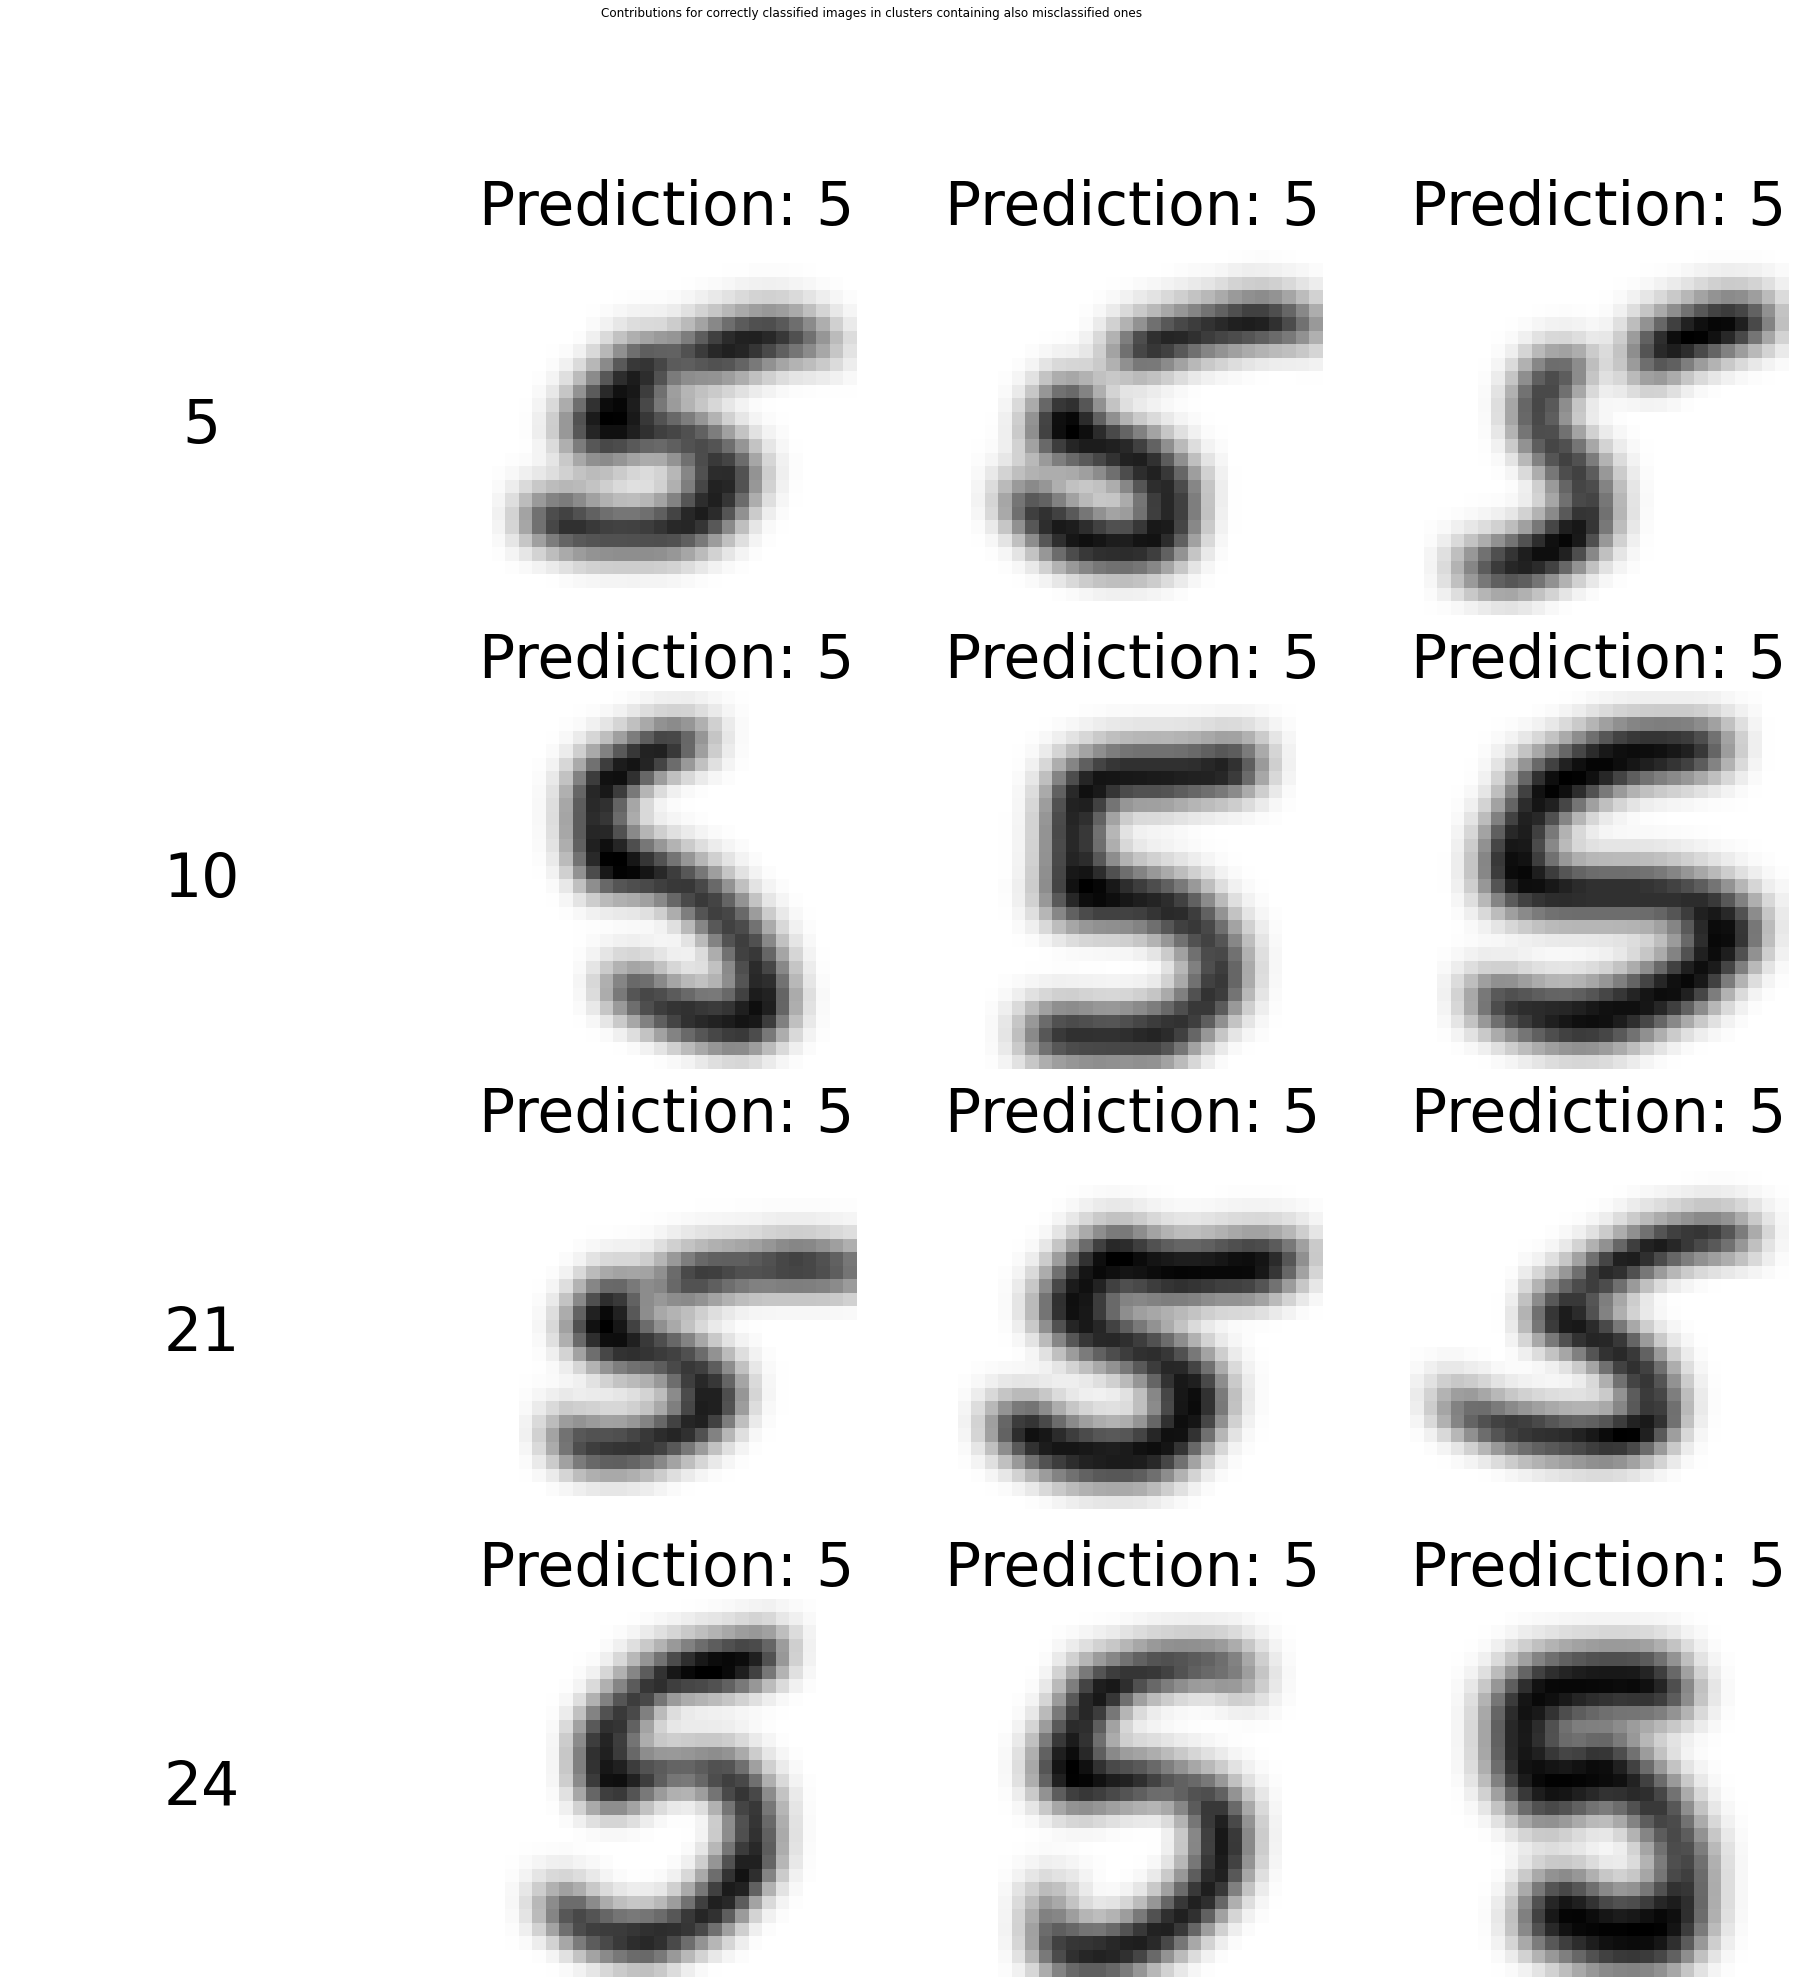

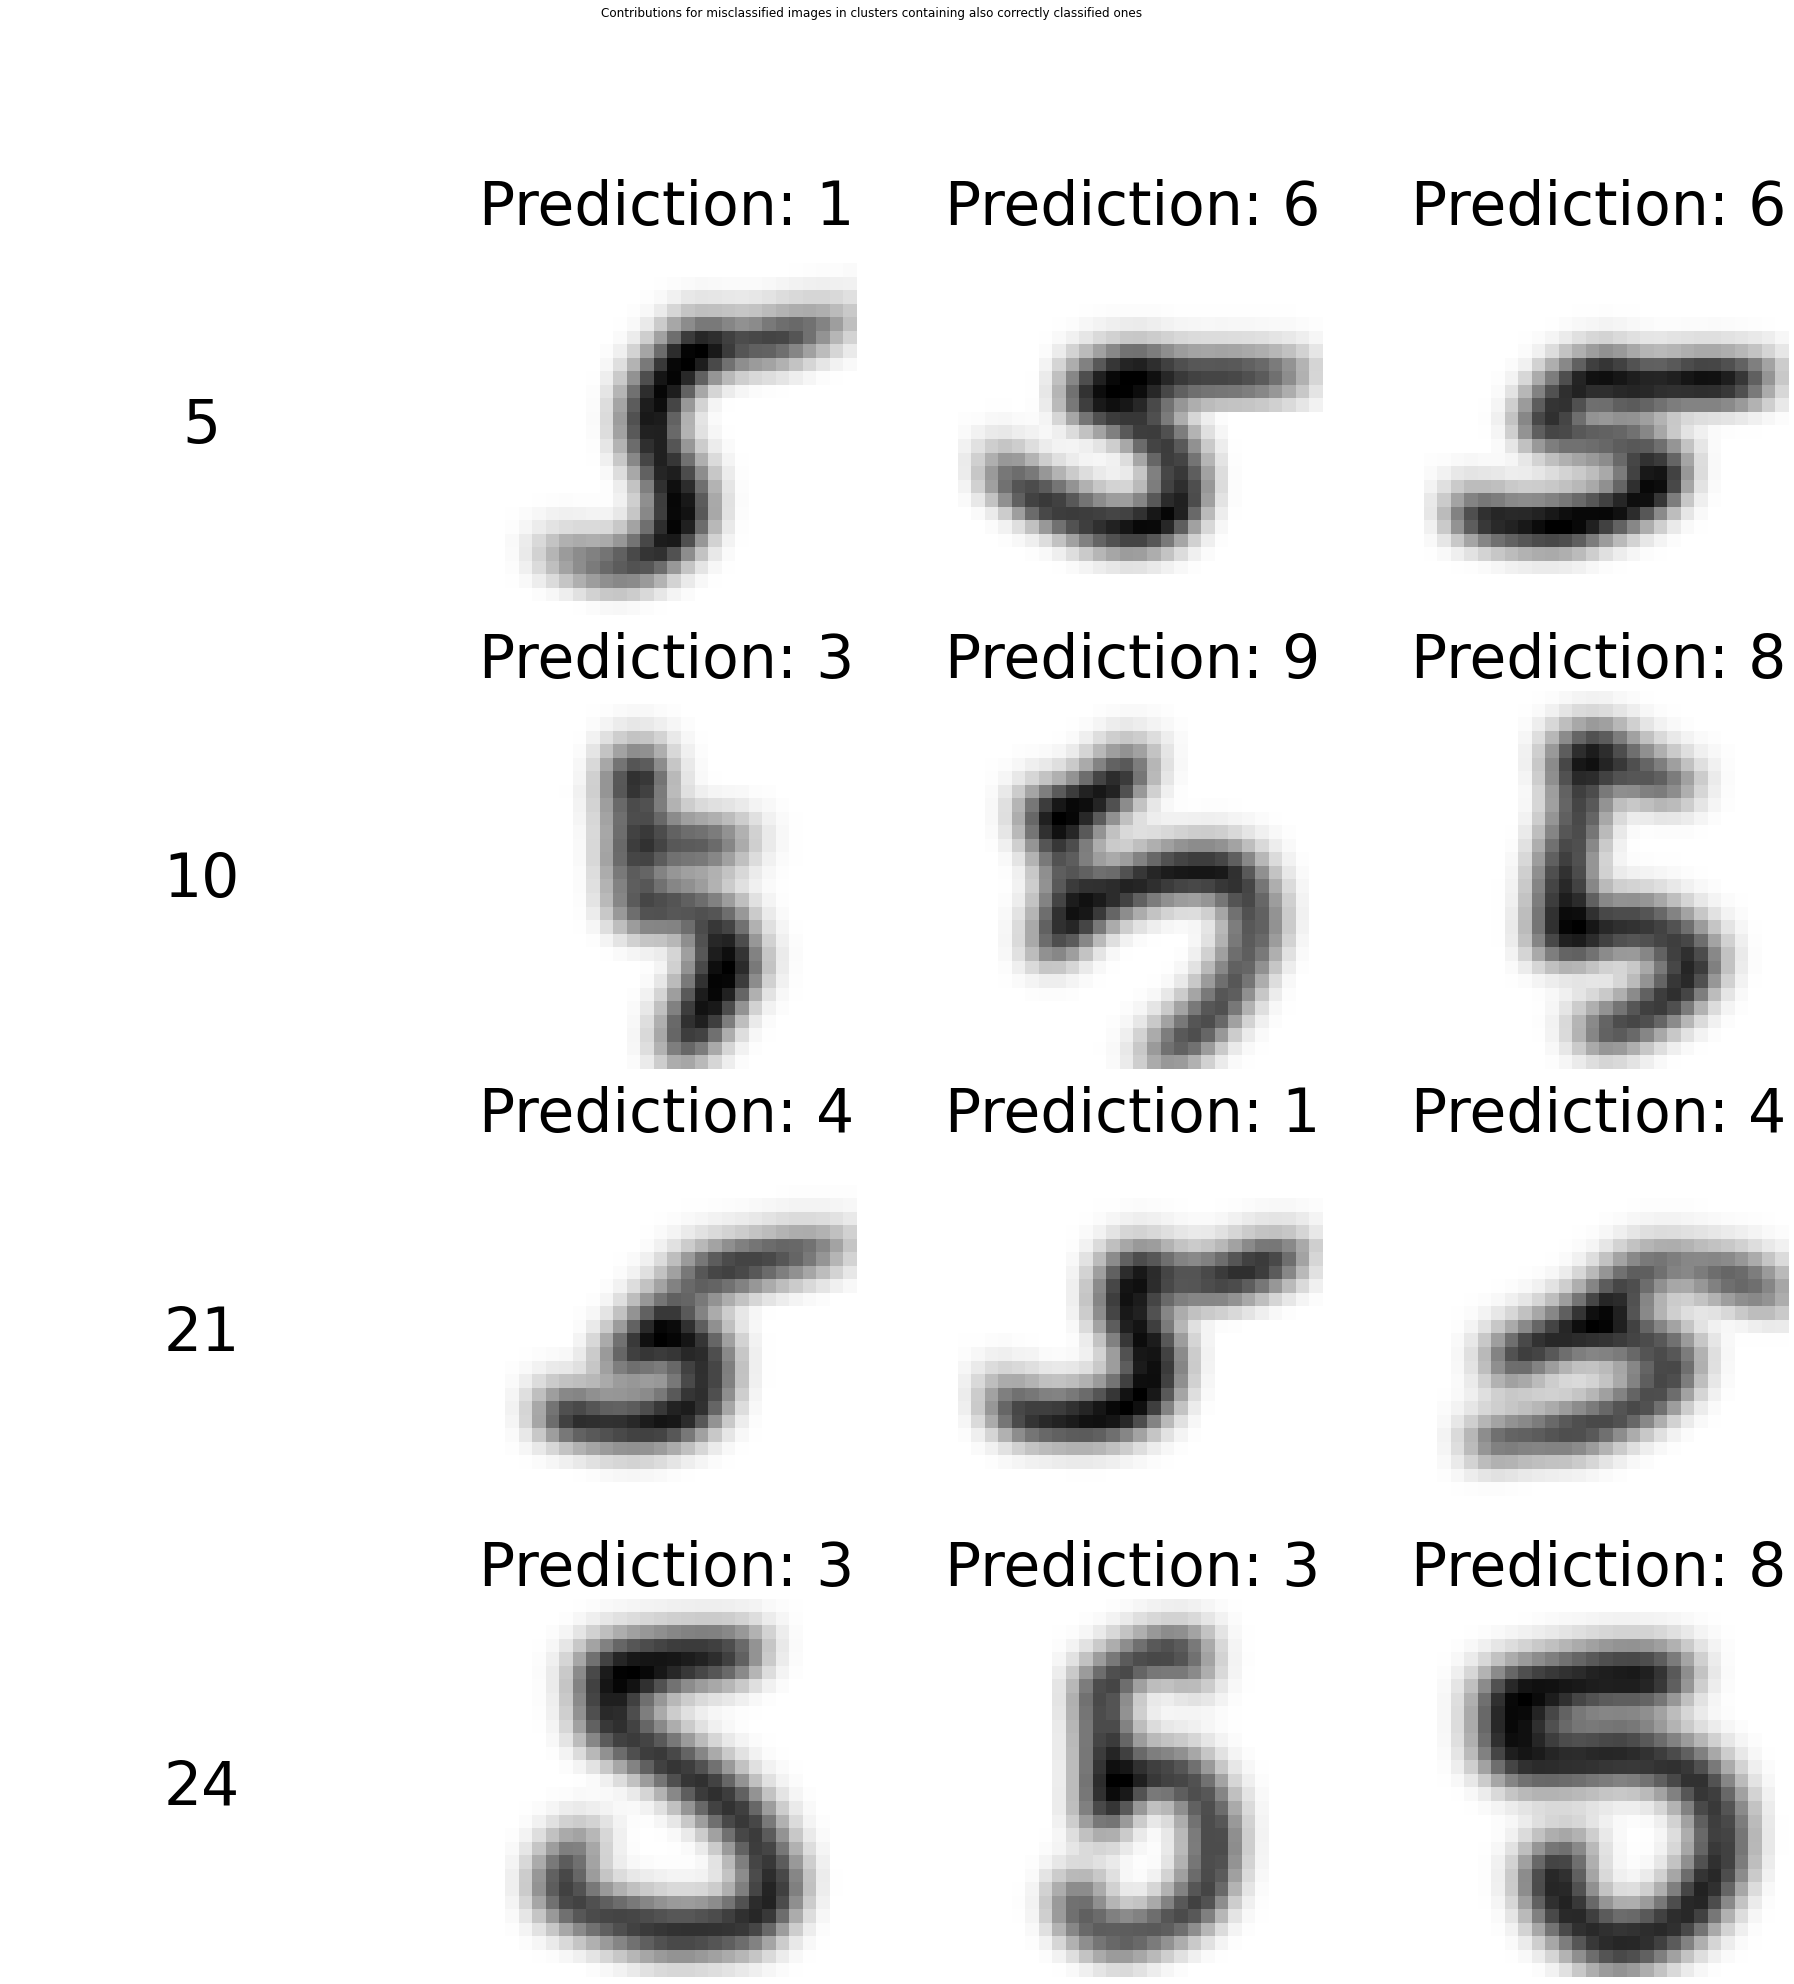

In [45]:
from utils.cluster.visualize import visualize_clusters_images

# sample some clusters labels containing misclassified items
sample_labels = np.random.choice(np.unique(clusters[mask_contains_miss_label]), 4, replace=False)

sample_mask = np.isin(clusters, sample_labels)
# show some correctly classified images for clusters containing also misclassified images
fig, _ = visualize_clusters_images(
    clusters=clusters[mask_contains_miss_label & ~mask_miss_label & sample_mask],
    images=contributions[mask_contains_miss_label & ~mask_miss_label & sample_mask],
    predictions=predictions[mask_label][mask_contains_miss_label & ~mask_miss_label & sample_mask],
    max_labels=4, max_samples=3,
    cmap='gray_r'
)
fig.suptitle('Contributions for correctly classified images in clusters containing also misclassified ones')
save_figure(fig, f'{base_dir}/clusters_correct_contributions')
# show some incorrectly classified images for clusters containing also misclassified images
fig, _ = visualize_clusters_images(
    clusters=clusters[mask_contains_miss_label & mask_miss_label & sample_mask],
    images=contributions[mask_contains_miss_label & mask_miss_label & sample_mask],
    predictions=predictions[mask_label][mask_contains_miss_label & mask_miss_label & sample_mask],
    max_labels=4, max_samples=3,
    cmap='gray_r'
)
fig.suptitle('Contributions for misclassified images in clusters containing also correctly classified ones')
save_figure(fig, f'{base_dir}/clusters_misclassified_contributions')

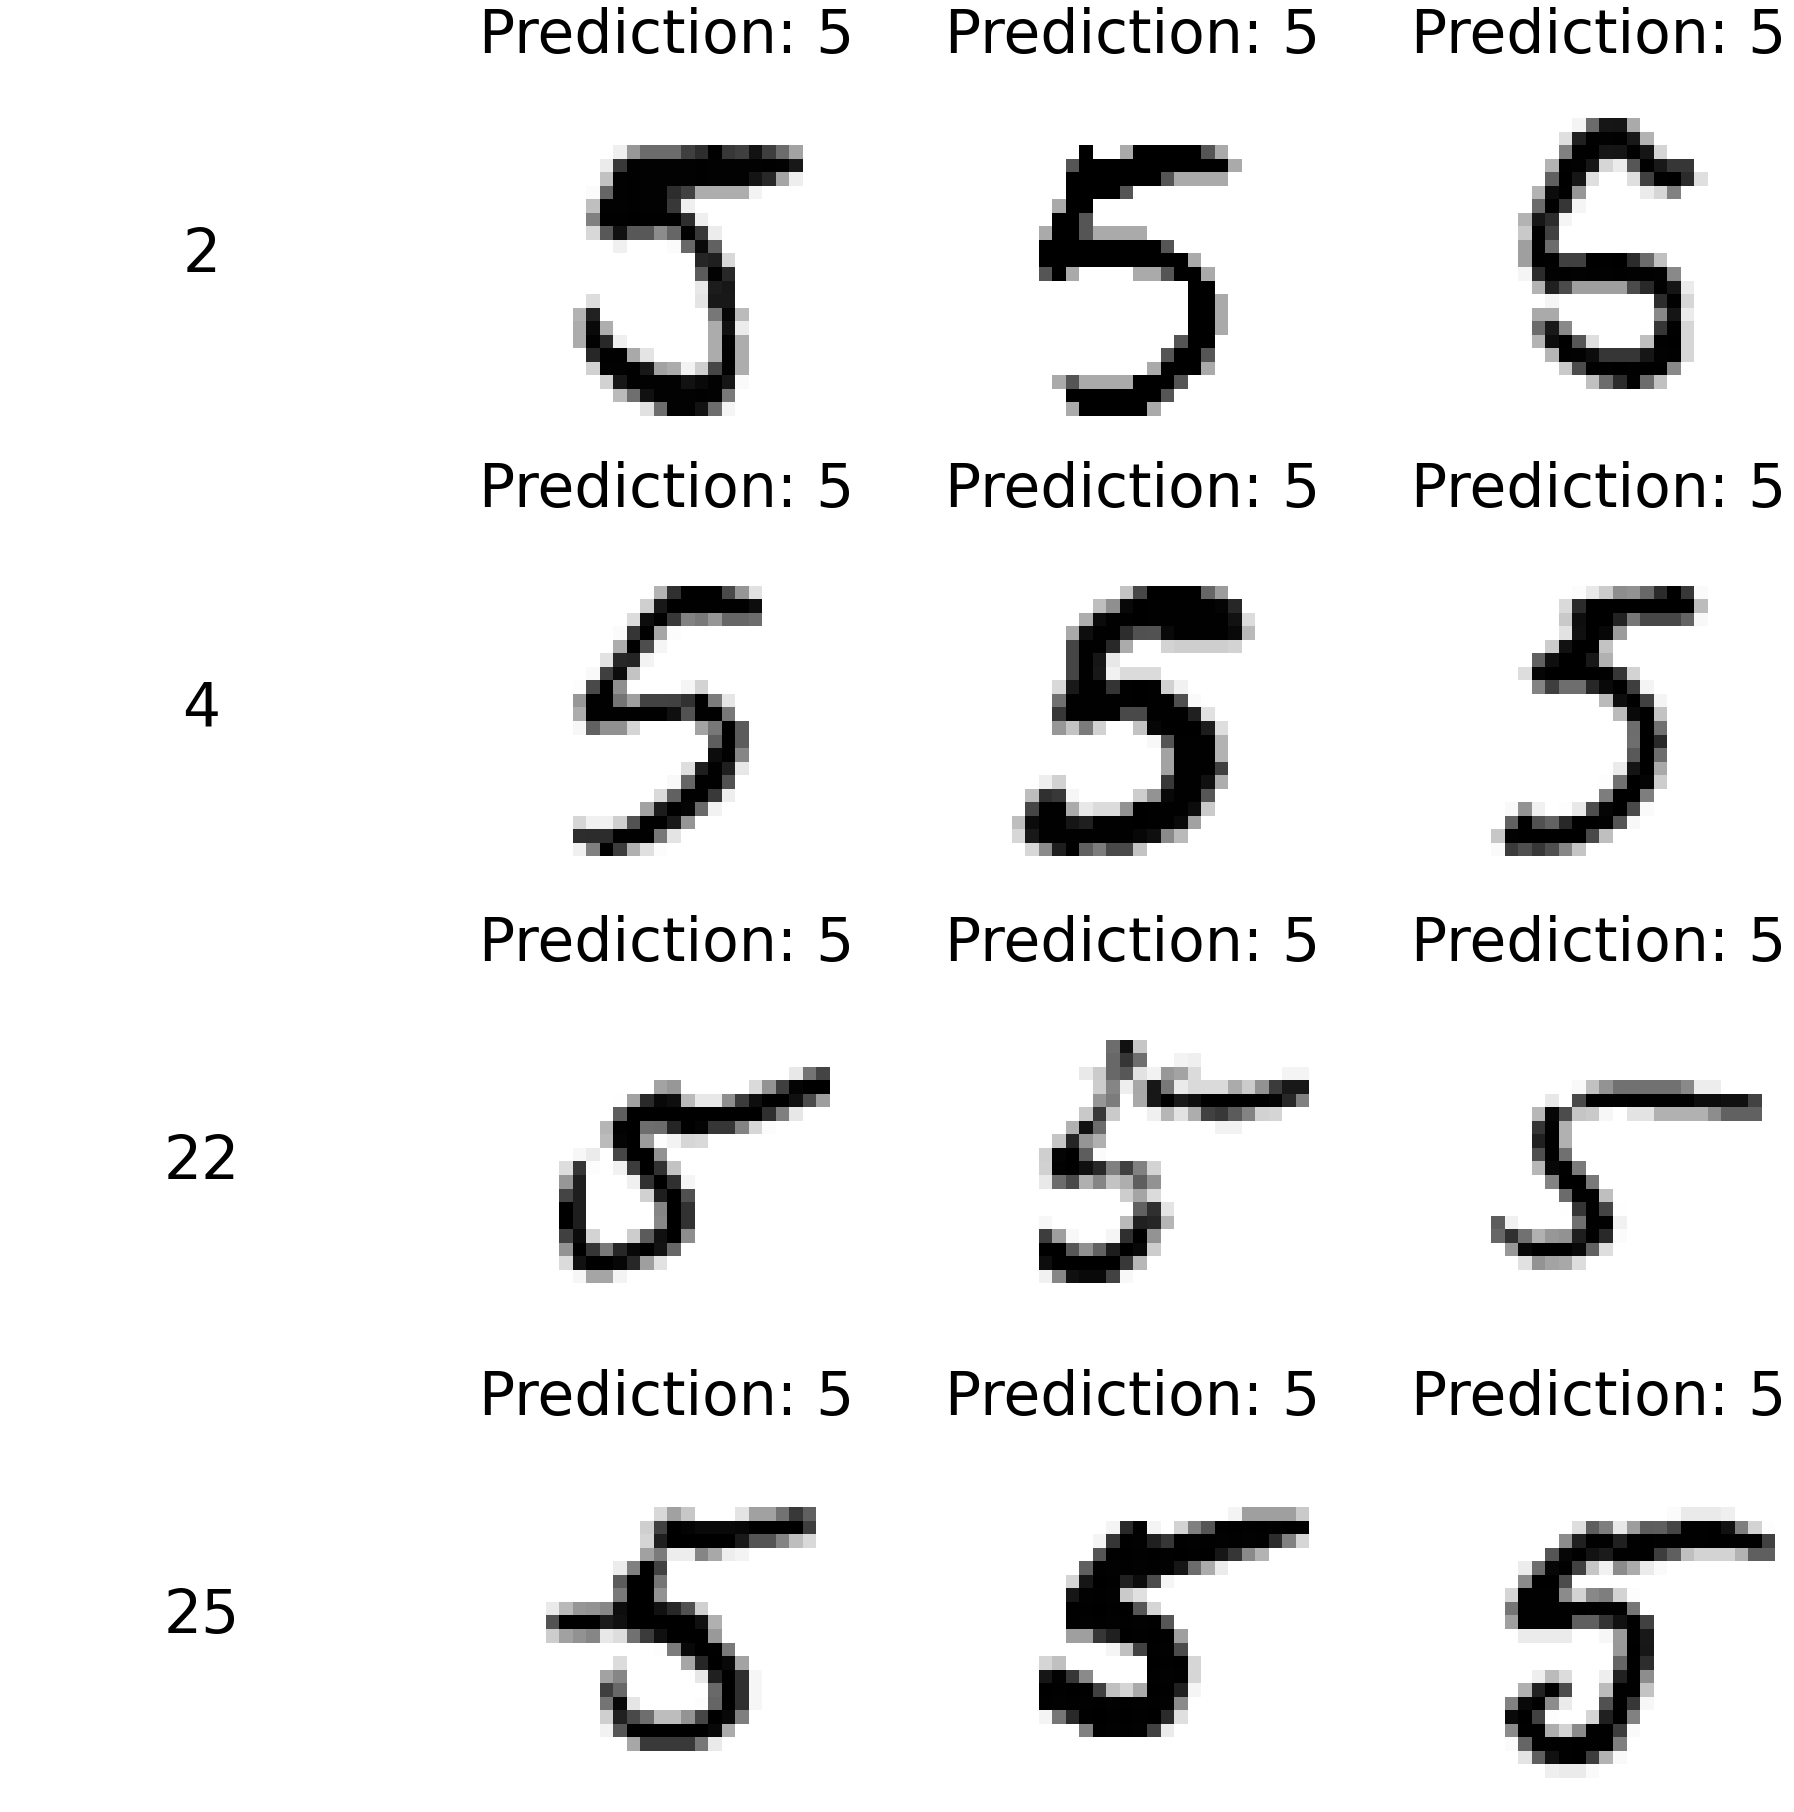

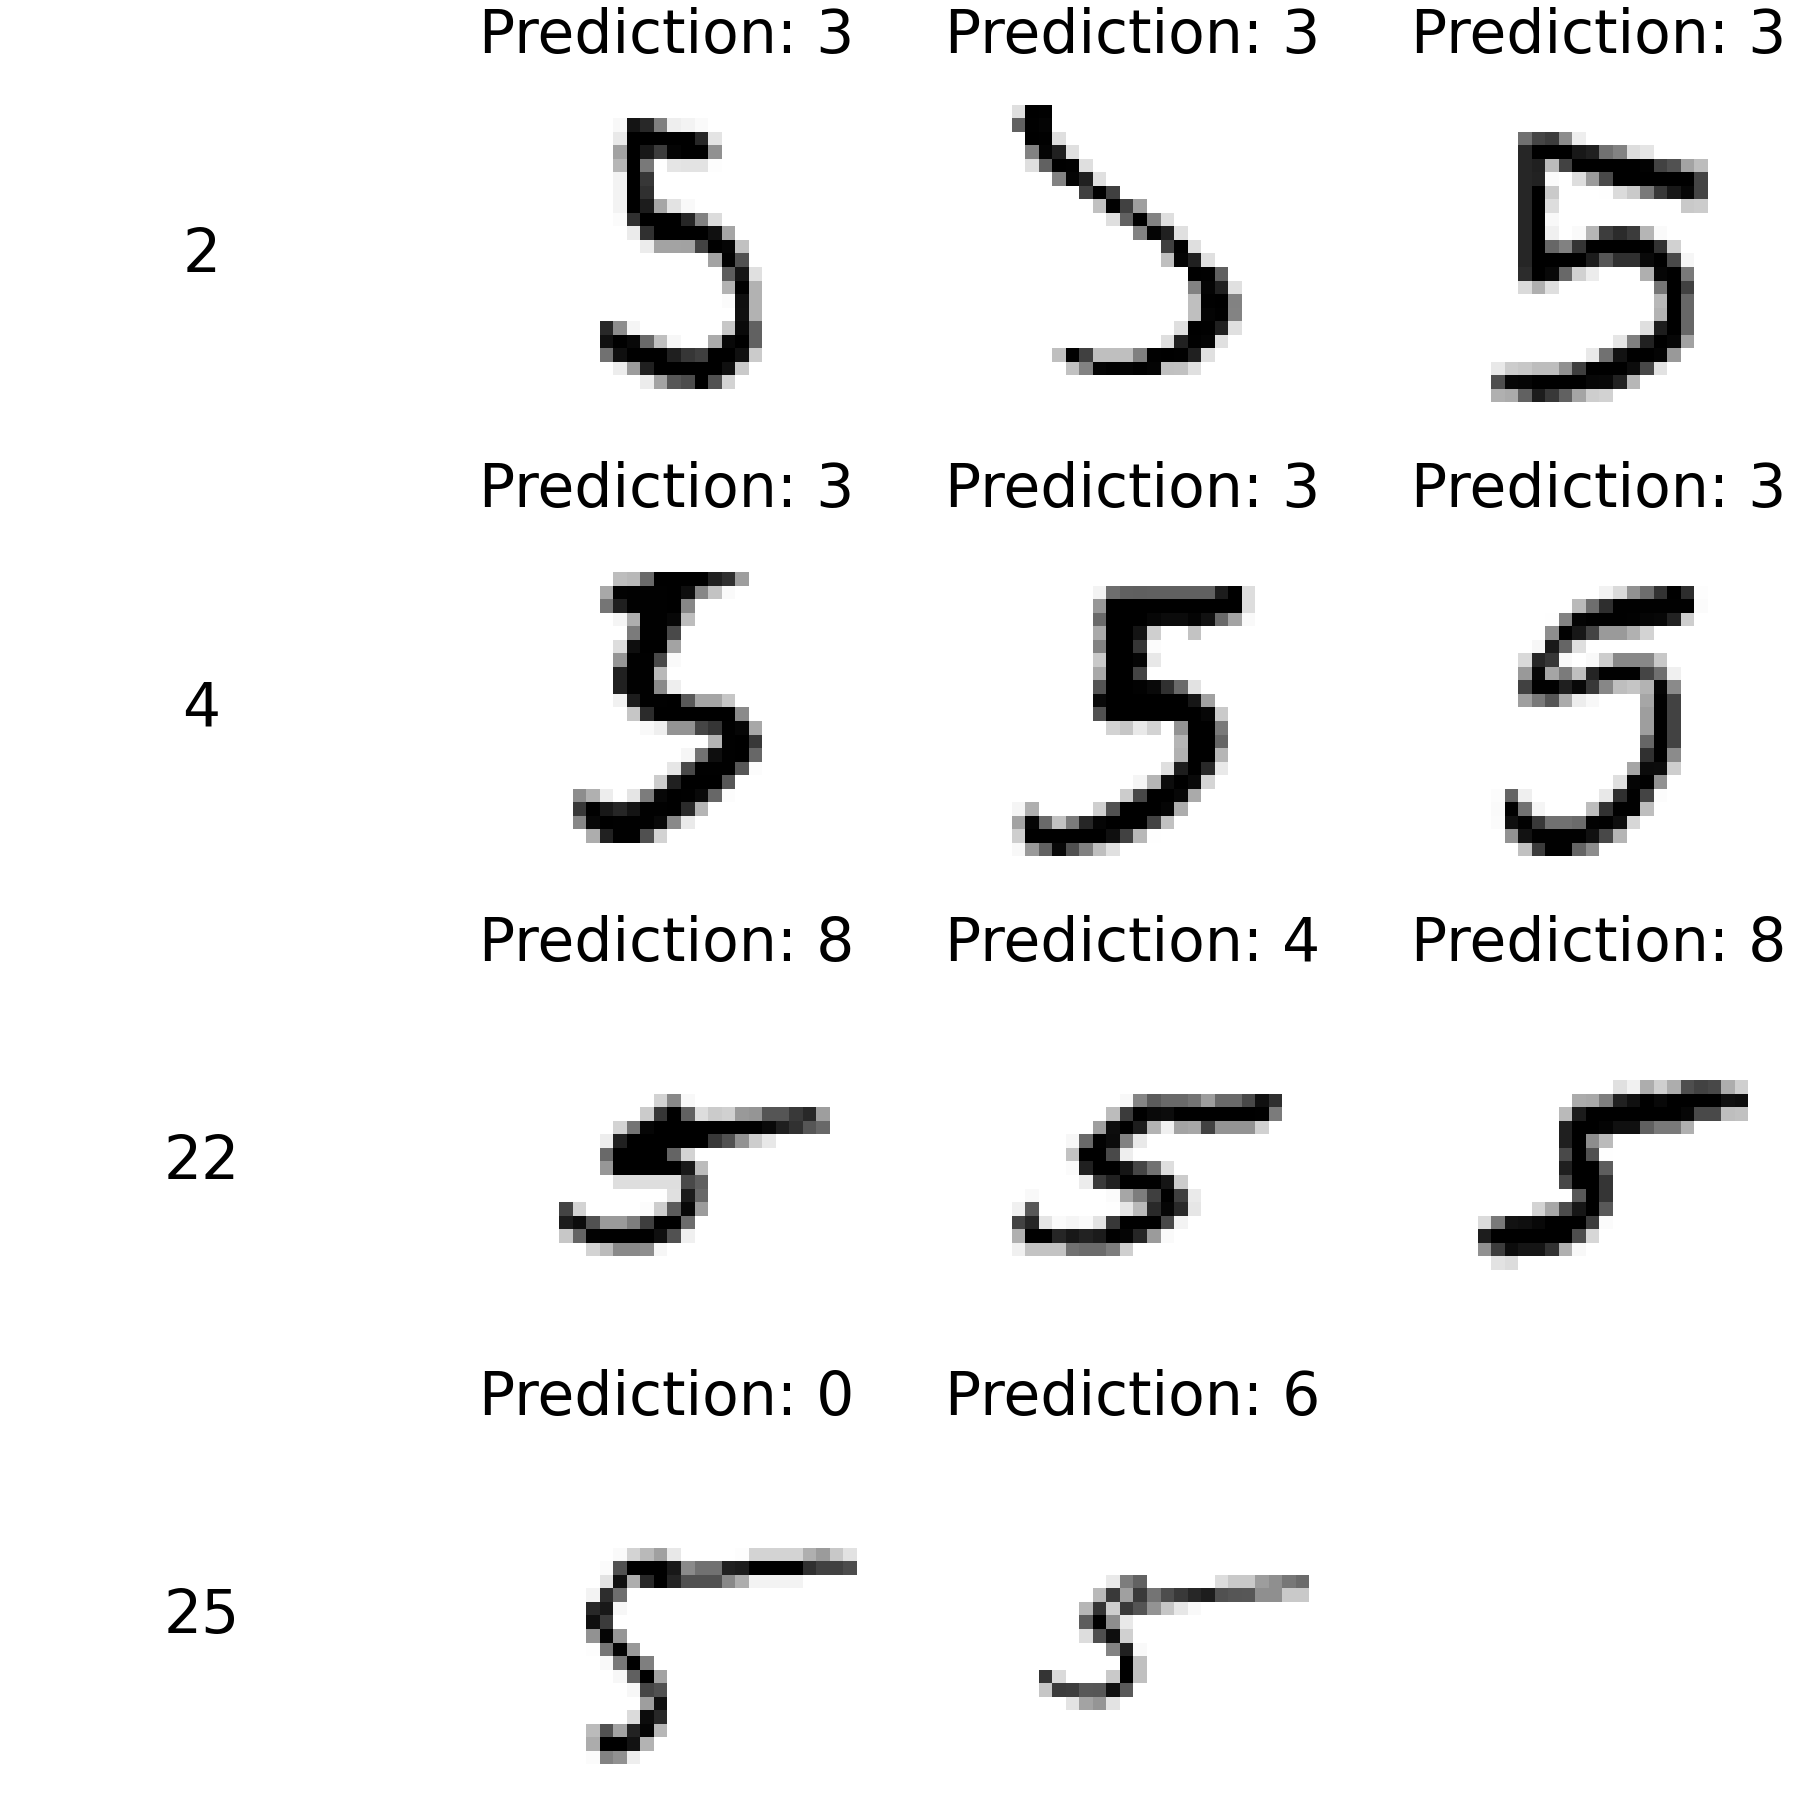

In [46]:
from utils.cluster.visualize import visualize_clusters_images

# sample some clusters labels containing misclassified items
sample_labels = np.random.choice(np.unique(clusters[mask_contains_miss_label]), 4, replace=False)

sample_mask = np.isin(clusters, sample_labels)
# show some correctly classified images for clusters containing also misclassified images
fig, _ = visualize_clusters_images(
    clusters=clusters[mask_contains_miss_label & ~mask_miss_label & sample_mask],
    images=test_data_gs[mask_label][mask_contains_miss_label & ~mask_miss_label & sample_mask],
    predictions=predictions[mask_label][mask_contains_miss_label & ~mask_miss_label & sample_mask],
    max_labels=4, max_samples=3,
    cmap='gray_r'
)
save_figure(fig, f'{base_dir}/clusters_correct_images')
# show some incorrectly classified images for clusters containing also misclassified images
fig, _ = visualize_clusters_images(
    clusters=clusters[mask_contains_miss_label & mask_miss_label & sample_mask],
    images=test_data_gs[mask_label][mask_contains_miss_label & mask_miss_label & sample_mask],
    predictions=predictions[mask_label][mask_contains_miss_label & mask_miss_label & sample_mask],
    max_labels=4, max_samples=3,
    cmap='gray_r'
)
save_figure(fig, f'{base_dir}/clusters_misclassified_images')

In [51]:
len(set(clusters))

27